# Global vaccination and transportation control with vaccine sharing

In [1]:
import numpy as np
from scipy.optimize import minimize
from Epidemic_moudule import *
from Epidemic_moudule_plain import *
import pickle
import csv
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

## Load data and preprocess

In [2]:
covid_path = '/Programs/Chapter 5 Global Network/Program_data/Apt_pandemic_init_data.csv'
travel_path =  '/Programs/Chapter 5 Global Network/Program_data/region_air_passenger.csv'
commute_path = '/Programs/Chapter 5 Global Network/Program_data/Commut_rate.csv'
#name_path = '/Users/liuyang/Library/Mobile Documents/com~apple~CloudDocs/科研/Programs/Transport_Commute/Data/Region_code.csv'


N_p = {} #the dict to store population data {area code: population}
N_0 = {}  # the dict to store the initial health state data {area code: [S,V, L, I_a, I_t, I_nt, R]}
with open(covid_path, newline='') as covid_f:
    covid_reader = csv.reader(covid_f, delimiter= ' ', quotechar='|')
    next(covid_reader, None)
    for row in covid_reader:
        (c_code, r_code, a_code, a_name, t_pop, S, V, L, I, R)=row[0].split(',')
        N_p[int(a_code)] = int(t_pop)
        N_0[int(a_code)]= [float(S),float(V), float(L),float(I),float(R)]       

                
X = {} #the dict to store travel data {(date, dep, arr): passenger count}
with open(travel_path, newline='') as travel_f:
    travel_reader = csv.reader(travel_f, delimiter= ' ', quotechar='|')
    next(travel_reader, None)
    for row in travel_reader:
        (dep, arr,d_apt, a_apt, d_cou, a_cou, pcnt)=row[0].split(',')
        #print(dep, arr)
        X[(int(dep), int(arr))] = float(pcnt)



sigma = {} #the dict to store the commuting rate data, {(residence, work): commute rate}
with open(commute_path, newline='') as com_f:
    com_reader = csv.reader(com_f, delimiter= ' ', quotechar='|')
    next(com_reader, None)
    for row in com_reader:
        (res, wor, rate)=row[0].split(',')
        sigma[(int(res), int(wor))] = float(rate)
for l in sigma:
    if l[0]==l[1]:
        sigma[l]=0        


In [3]:
with open('PKL_files/country_airport.pkl', 'rb') as file:
    C_R = pickle.load(file)
for c in C_R:
    C_R[c] = sorted(C_R[c])

In [4]:
with open('PKL_files/Contact_rate(country).pkl', 'rb') as file:
    kpa_c = pickle.load(file)

kpa = {}
for c in C_R:
    for j in C_R[c]:
        kpa[j] = kpa_c[c]

In [5]:
# make the transport matrix symmetric 

X_new = {}
for l in X.keys():
    if (l[1], l[0]) not in X:
        X_new[(l[1], l[0])] = X[l]
X.update(X_new)

for l in X:
    if X[l] > X[(l[1], l[0])]:
        X[(l[1], l[0])] = X[l]


In [6]:
C_ne = {}

for (o, d), rate in sigma.items():
    if o not in C_ne:
        C_ne[o] = []
    C_ne[o].append(d)
    
    
for c in C_R:
    for j in C_R[c]:
        if j not in C_ne:
            C_ne[j] = []

In [7]:
### get the domestic and international neighbour nodes 
# Initialize the results
A_ne_d = {}
A_ne_i = {}

# Step 1: Create {region: [other regions with domestic flow]}
for (origin, destination), flow in X.items():
    for country, regions in C_R.items():
        if origin in regions and destination in regions:
            if origin not in A_ne_d:
                A_ne_d[origin] = []
            if destination not in A_ne_d:
                A_ne_d[destination] = []
            A_ne_d[origin].append(destination)
            A_ne_d[destination].append(origin)

# Step 2: Create {region: {country: [regions in the country that the origin region have transport flow with]}}
for (origin, destination), flow in X.items():
    origin_country = None
    destination_country = None
    
    # Identify the countries for origin and destination regions
    for country, regions in C_R.items():
        if origin in regions:
            origin_country = country
        if destination in regions:
            destination_country = country
    
    # Initialize the nested dict structure
    if origin not in A_ne_i:
        A_ne_i[origin] = {}
    if destination not in A_ne_i:
        A_ne_i[destination] = {}
    
    # Add international flow information
    if destination_country != origin_country:
        if destination_country not in A_ne_i[origin]:
            A_ne_i[origin][destination_country] = []
        A_ne_i[origin][destination_country].append(destination)
    
    if origin_country != destination_country:
        if origin_country not in A_ne_i[destination]:
            A_ne_i[destination][origin_country] = []
        A_ne_i[destination][origin_country].append(origin)

# delete the duplicate values
A_ne_d = {j: list(set(A_ne_d[j])) for j in A_ne_d}
A_ne_i = {j: {c: list(set(A_ne_i[j][c])) for c in A_ne_i[j]} for j in A_ne_i}

for c in C_R: # add the unlisted regions into A_ne_d and A_ne_i
    for j in C_R[c]:
        if j not in A_ne_d:
            A_ne_d[j] = []
        if j  not in A_ne_i:
            A_ne_i[j] = {}

In [8]:
X_c = {} # mobility between country pairs
for c1 in C_R:
    for c2 in range(c1+1, 16):
        X_c[(c1, c2)] = 0
        for i in C_R[c1]:
            for j in C_R[c2]:
                if (i,j) in X:
                    X_c[(c1, c2)] += X[(i,j)]

## country pairs with no air mobility
no_air_country_pair = []
for l in X_c:
    if X_c[l] == 0:
        no_air_country_pair.append(l)
        no_air_country_pair.append((l[1], l[0]))

In [9]:
# get the total international mobility between countries 
air_int_mobility = {c1:{c2:0 for c2 in C_R if c2 != c1} for c1 in C_R}
for c1 in air_int_mobility:
    for c2 in air_int_mobility[c1]:
        for i in C_R[c1]:
            for j in C_R[c2]:
                if (i,j) in X:
                    air_int_mobility[c1][c2] += X[(i,j)]

In [10]:
# set parameters
v = 1/7               # infection period
xi = 1/1.1            # latent period
tau = 3               # return rate of daily commuters
#r = 1                # ratio of infectiousness of asymptomatic person
eta = 3               # coefficient to change the daily contact
t_s_dom = 1.8         # period of stay of domestic tourists
t_s_int = 6           # period of stay of international tourists
gamma_s = 0.007       # infection rate of unvaccinated individuals
gamma_v =0.0002       # infection rate of vaccinated individuals


c_b = {j:0.4 for j in N_p}   # cost coefficient of vaccination
c_i = {j:2 for j in N_p} 
c_d_d = 0.6  # long distance control cost for domenstic travel
c_d_i = 2.5  #long distance control cost for international travel

his_data = {'N_p':N_p, 'X':X, 'sigma':sigma, 'kpa':kpa}

epi_params = {'v': v, 'xi': xi, 'tau':tau, 'eta': eta, 't_s_dom':t_s_dom, 't_s_int':t_s_int,
              'gamma_s': gamma_s, 'gamma_v': gamma_v, 
              'c_b': c_b, 'c_i': c_i, 'c_d_d':c_d_d, 'c_d_i': c_d_i}

In [11]:
# total 184 days, 26.3 weeks
# get the actual vaccination data
vac_path = '/Programs/Chapter 5 Global Network/Program_data/Country_vaccine.csv'

country_vac = {} #the dict to store the real covid data, the active infective is a sum of 7 day increase
with open(vac_path, newline='') as vac_f:
    vac_reader = csv.reader(vac_f, delimiter= ' ', quotechar='|')
    next(vac_reader, None)
    for row in vac_reader:
        list_vac=row[0].split(',')
        country_vac[int(list_vac[0])] = [float(n) for n in list_vac[1:]]

vac_his_b = {c: [sum(country_vac[c][b*7:(b+1)*7]) for b in range(26)] for c in C_R}

country_name = ['AU', 'BN', 'CN', 'ID', 'IN', 'JP', 'KH', 'KR', 'LA', 'MM', 'MY', 'NZ', 'PH', 'SG', 'TH', 'VN']

In [12]:
def model_dynamic(params, num_country, num_region, N, days, T_days, c_code):
    
    delta = params[:num_country]
    
    beta = {C_R[c_code][i] : params[num_country+i] for i in range(num_region)}
    
    Epi_res = Epidemic_solution(his_data, N, C_ne, A_ne_i, A_ne_d, epi_params, days, beta, delta, c_code, C_R)
    state_new, cost = Epi_res.get_res()
    
    Epi_res_p = Epidemic_solution_p(his_data, state_new, C_ne, A_ne_i, A_ne_d, epi_params, T_days-days, beta, delta, c_code, C_R)
    state_new_p, cost_p = Epi_res_p.get_res()
    
    cost_sum = cost + cost_p
    return cost_sum


def epidemic_update(delta, beta, N, days, c_code): # calculate the 
    
    #delta = params[:num_country]
    #beta = {C_R[c_code][i] : params[num_country+i] for i in range(num_region)}
    
    Epi_res = Epidemic_solution(his_data, N, C_ne, A_ne_i, A_ne_d, epi_params, days, beta, delta, c_code, C_R)
    state_new, cost = Epi_res.get_res()
    
    return state_new

In [13]:
def vaccine_share(N, vac_avail, v_result_b, t_result_b, b):
    # v_result_b = {j : vaccination_rate}
    f1_db = {} # f'(d,b)
    vac_use = {c: sum(N[j][0]*v_result_b[j]*7 for j in C_R[c]) for c in C_R}
    #vac_avail = {c:sum(N[j][0]*vac_range[c][1]*7 for j in C_R[c]) for c in C_R}
    for c in C_R:
        if vac_use[c] < vac_avail[c]*0.95:
            f1_db[c] = 0
        else:
            f1_db[c] = 1
   
    f_db = {c:{} for c in C_R}   # f(d1, d2, b)
    inf_ratio = {c: sum(N[j][3] for j in C_R[c])/sum(N_p[j] for j in C_R[c]) for c in C_R}
    for c1 in C_R:
        for c2 in C_R:
            if c1 != c2:
                f_db[c1][c2] = air_int_mobility[c1][c2]*t_result_b[c1, c2]*inf_ratio[c2]*f1_db[c2]
    
    # vac_sharing_d1,d2 (b+1)
    vac_s_d_bp1 = {c:{} for c in C_R}
    for c1 in C_R:
        f_d1db_sum = sum(f_db[c1][c] for c in f_db[c1])
        for c2 in C_R:
            if c1 != c2:
                vac_s_d_bp1[c1][c2] = (1-f1_db[c1])*f_db[c1][c2]/f_d1db_sum*(vac_avail[c1]-vac_use[c1])
                
    vac_avail_bp1 = {c: min(max(vac_his_b[c])*1.2, vac_his_b[c][b+1]+sum(vac_s_d_bp1[c1][c] for c1 in C_R if c1 != c)) for c in C_R} # vac available for b+1 period
    return vac_avail_bp1

## All period and all countries calculation

/var/folders/7h/xrfygzbx6nl26f871jzjhqgh0000gn/T/ipykernel_94865/673443609.py:54: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  t_control[b] = np.vstack((t_con_tem[c] for c in t_con_tem)) # store unadjusted mobility control array
/var/folders/7h/xrfygzbx6nl26f871jzjhqgh0000gn/T/ipykernel_94865/673443609.py:61: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  T_array_adjusted = np.vstack((t_con_tem[c] for c in t_con_tem))


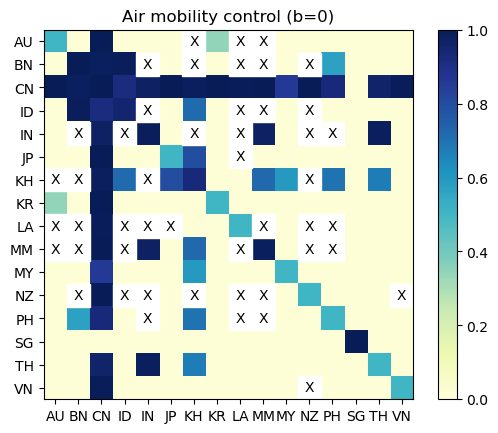

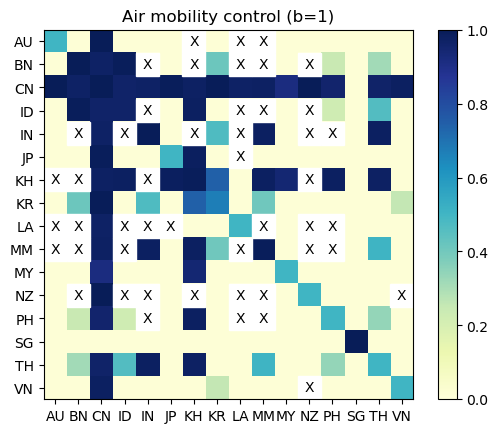

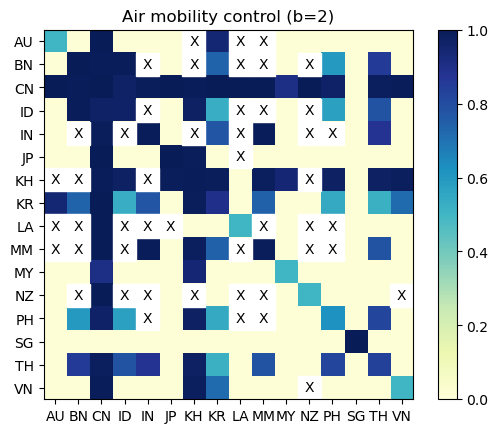

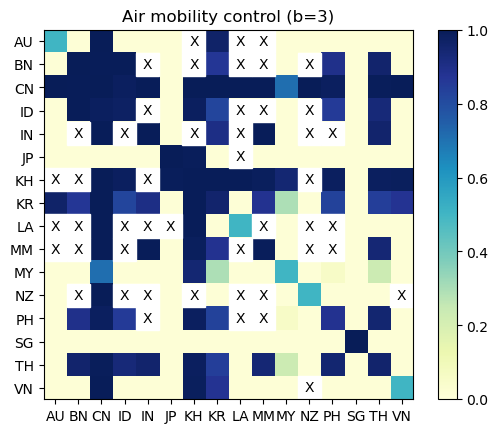

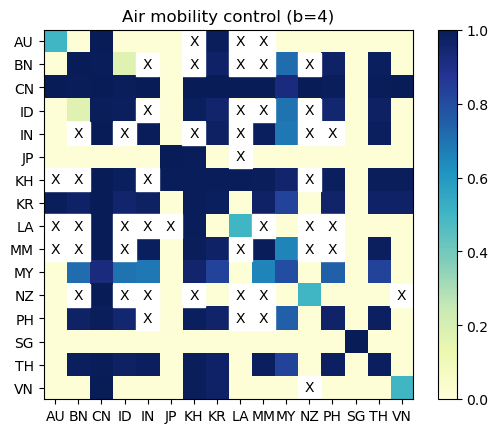

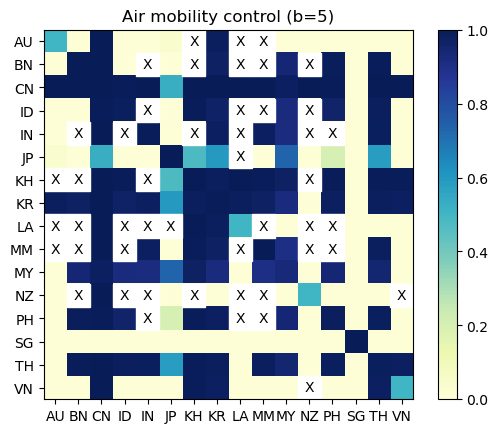

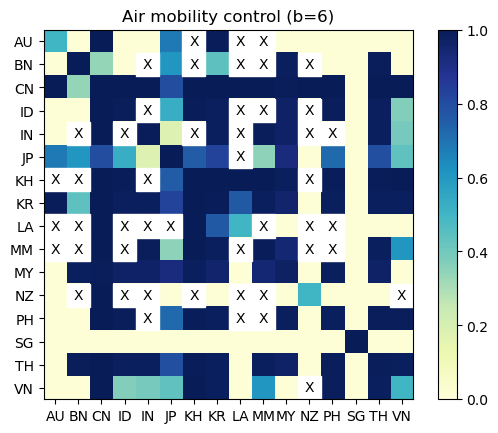

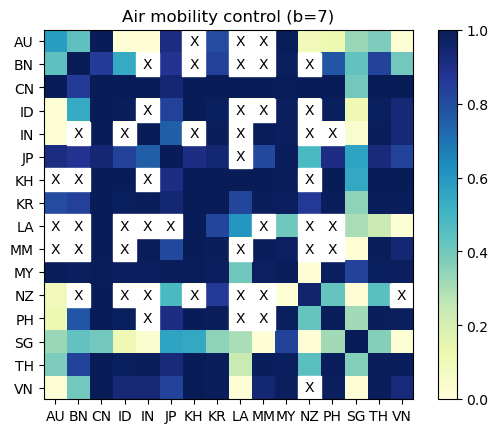

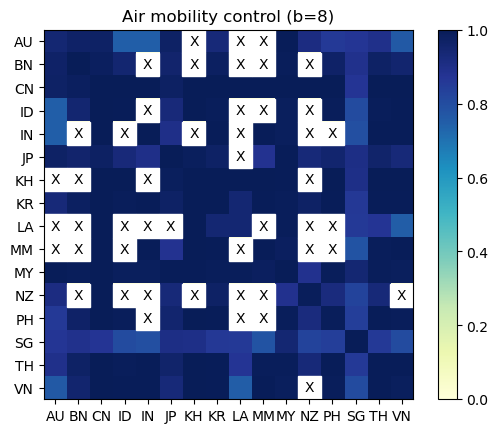

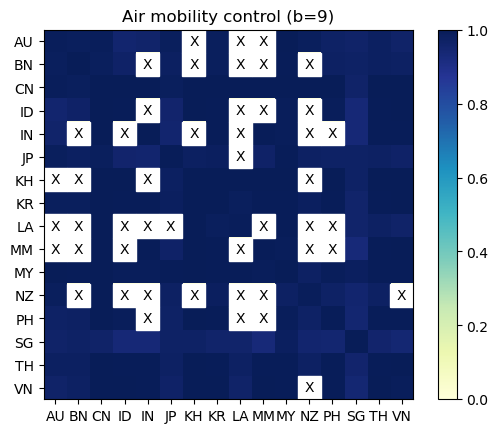

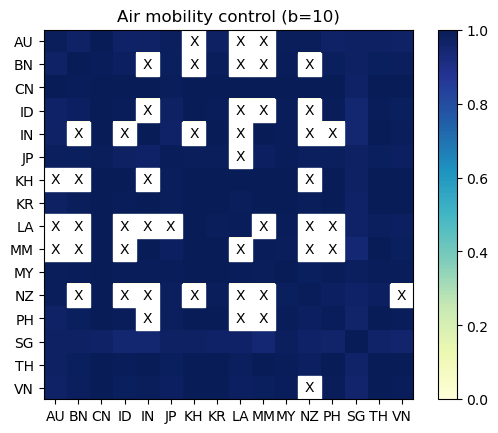

/var/folders/7h/xrfygzbx6nl26f871jzjhqgh0000gn/T/ipykernel_94865/1122877594.py:25: RuntimeWarning: invalid value encountered in double_scalars
  vac_s_d_bp1[c1][c2] = (1-f1_db[c1])*f_db[c1][c2]/f_d1db_sum*(vac_avail[c1]-vac_use[c1])


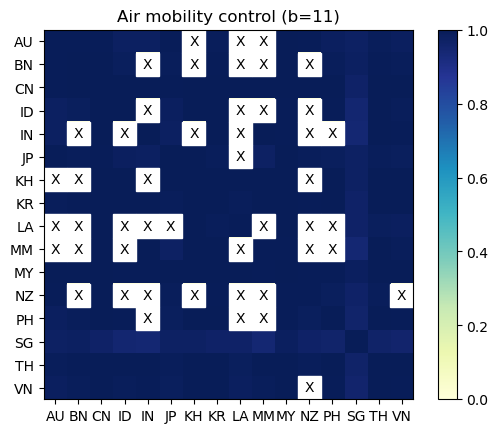

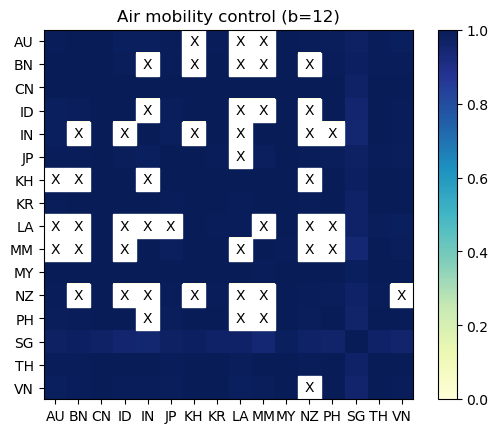

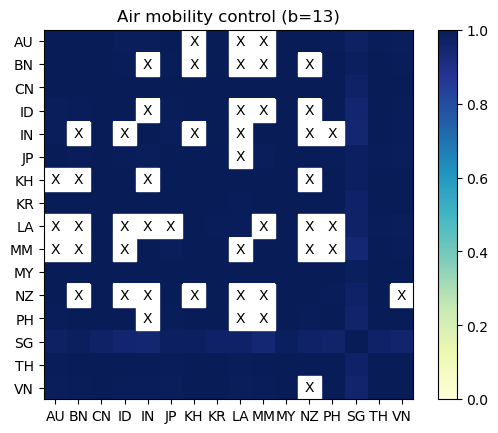

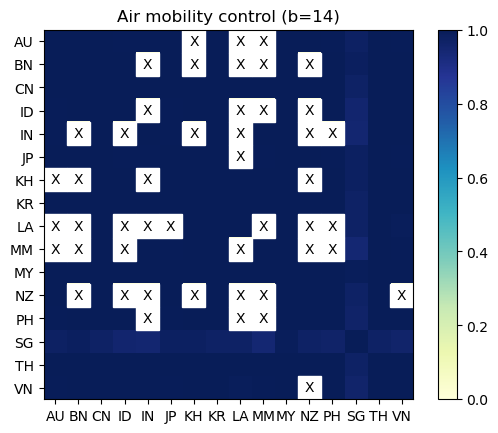

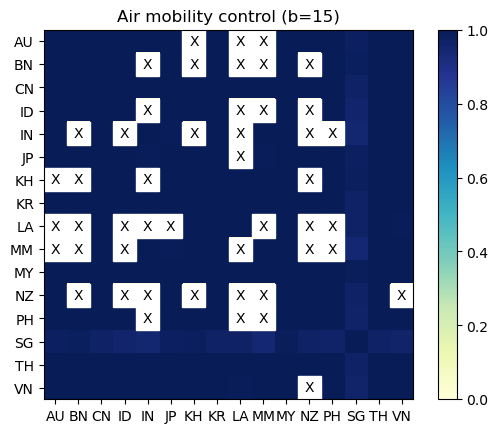

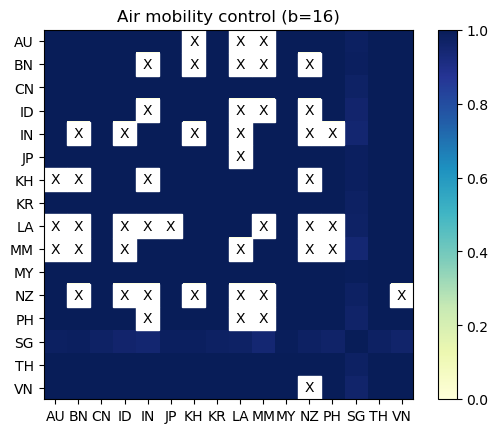

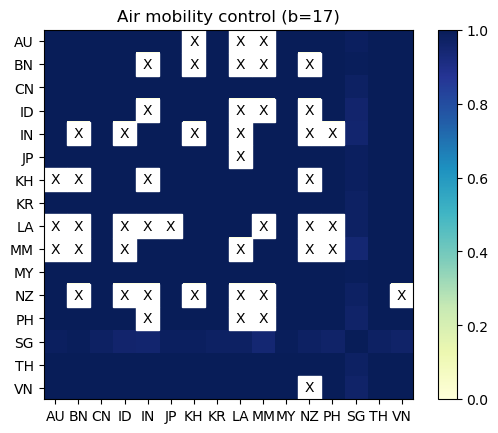

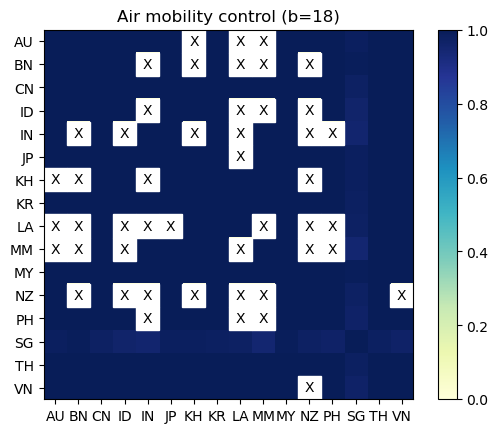

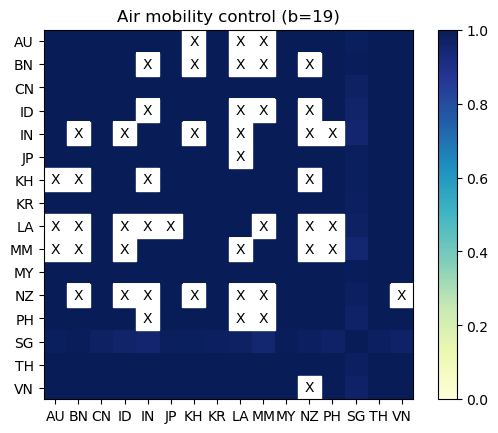

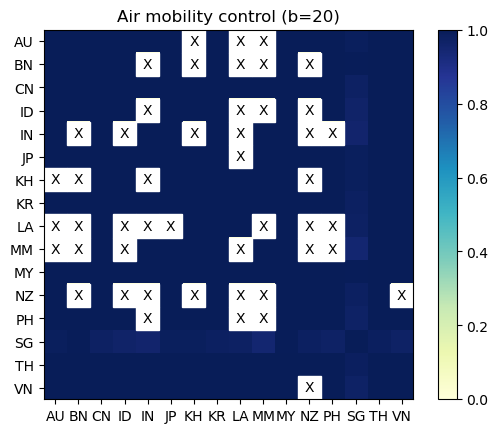

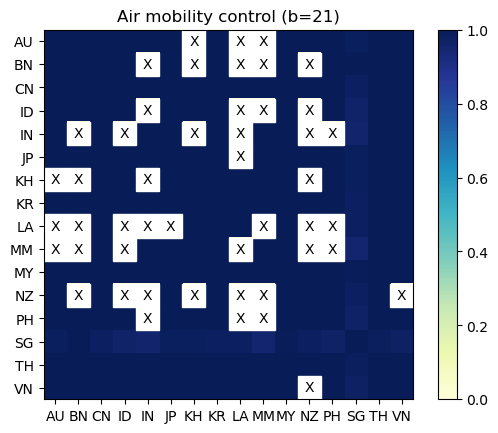

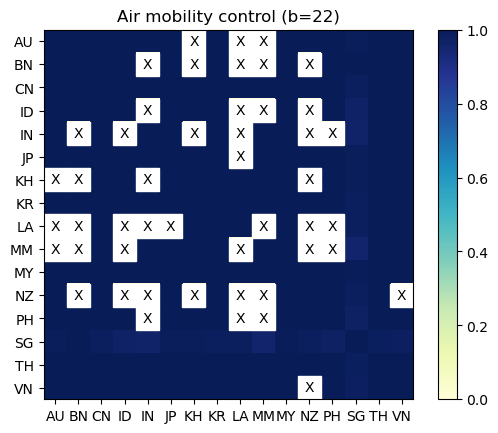

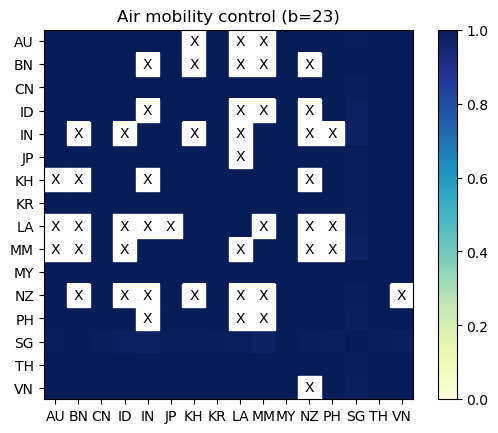

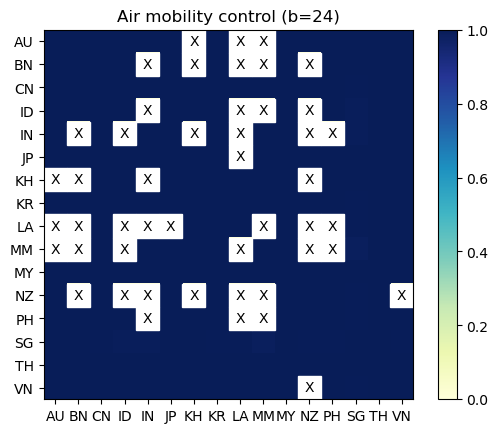

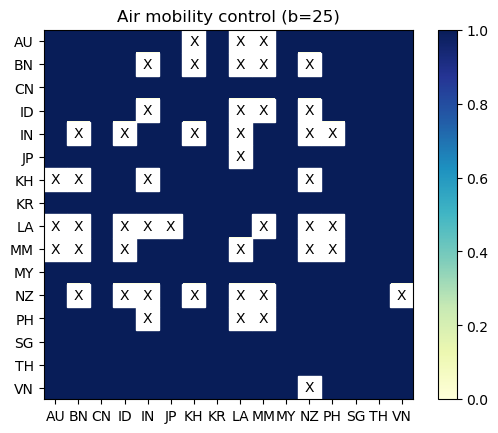

In [22]:

t_control = {}
t_control_a = {}
v_control = {}

epidemic_weekly = {}

shared_vac = []

num_country = 16
Total_days = 182 # total 26 weeks
days = 7

N = N_0 # install the initial epidemic data
vac_avail = {c: vac_his_b[c][0] for c in C_R} # vaccine at b=0

for b in range(26):

    v_control[b] = {} # vaccination control result storage at period b
    
    vac_range = {}   # get the vaccination rate range from actual data
    for c in C_R:
        S_c = sum(N[j][0] for j in C_R[c])
        V_c = sum(country_vac[c][b*7:(b+1)*7])
        vac_range[c] = (vac_his_b[c][b]/7/S_c/3, vac_avail[c]/7/S_c) # real vaccination rate as max, 50% of real vaccine rate as min

    t_con_tem = {} # temporary storage for transport control 
    
    for c in C_R: # calculate the control results for this time period
        c_code = c # country code
        num_region = len(C_R[c])
        initial_params = np.concatenate((np.ones(num_country), np.ones(num_region)*vac_range[c][1]))

        V_range = vac_range[c]
        # transport control vaccination rate range
        bounds = [(0.01, 1) for _ in range(num_country)] + [ V_range for _ in range(num_region)]  
        bounds[c] = (0.5,1) # change the domestic control range to (0.5, 1)
        result = minimize(
            model_dynamic,
            initial_params,
            args=(num_country, num_region, N, days, Total_days-(b*7), c),
            bounds=bounds,
            method='L-BFGS-B',
            #constraints={'type': 'ineq', 'fun': vac_constraint, 'args': (num_links, init_state, vac_limit, days)}
        )

        t_con_tem[c] = result.x[:num_country]
        for j in C_R[c]:
            v_control[b][j] = result.x[num_country:][j-C_R[c][0]]
        #print(c, 'complete')
    # change the unpaired mobility links to 0
    for l in no_air_country_pair:
        t_con_tem[l[0]][l[1]] = 0
    
    t_control[b] = np.vstack((t_con_tem[c] for c in t_con_tem)) # store unadjusted mobility control array
    
    # get the symmetric matrix of transport control
    for c1 in t_con_tem:
        for c2 in t_con_tem:
            if t_con_tem[c1][c2] > t_con_tem[c2][c1]:
                t_con_tem[c1][c2] = t_con_tem[c2][c1]
    T_array_adjusted = np.vstack((t_con_tem[c] for c in t_con_tem))
    
    # store results to T_control dict
    t_control_a[b] = T_array_adjusted
    
    # plot the control map
    plt.imshow(T_array_adjusted, cmap='YlGnBu', interpolation='nearest')
    plt.colorbar()  
    plt.title('Air mobility control (b={0})'.format(b))
    plt.xticks(range(16), country_name)
    plt.yticks(range(16), country_name)
    for (i, j) in no_air_country_pair:
        plt.fill([j-0.5, j+0.5, j+0.5, j-0.5], [i-0.5, i-0.5, i+0.5, i+0.5], color='white')
        plt.text(j, i, 'X', ha='center', va='center', color='black')
    plt.show()
    
    # get vaccine sharing 
    if b < 25:
        vac_avail_new = vaccine_share(N, vac_avail, v_control[b], t_control_a[b], b)
        vac_avail = vac_avail_new
        shared_vac.append(sum(vac_avail[c]- vac_his_b[c][b+1] for c in C_R))
    #### get the adjusted pandemic results with adjusted transport control
    
    N_new = {}
    
    for c in C_R:
        delta = T_array_adjusted[c].tolist()
        beta = {j: v_control[b][j] for j in C_R[c]}
        state_new = epidemic_update(delta, beta, N, days, c)

        for j in state_new:
            N_new[j] = state_new[j]
    
    epidemic_weekly[b+1] = N_new
    N = N_new


## Output data to PKL files

In [20]:
epidemic_weekly[0] = N_0

In [21]:
# filenames, explination
# t_control(adjusted_V_s).pkl: transport control, adjusted, with vaccination control, no vaccine sharing
# t_control(unadjusted_V_s).pkl: transport control, unadjusted, with vaccination control, no vaccine sharing
# v_control(V_s).pkl: vaccination control result, no vaccine sharing
# epidemic_weekly(V_s).pkl: epidemic updated for each b, with vaccination control, no vaccine sharing
# 

with open('PKL_files/VTC-S_t_control(adjusted).pkl', 'wb') as file:
    pickle.dump(t_control_a, file)

with open('PKL_files/VTC-S_t_control(unadjusted).pkl', 'wb') as file:
    pickle.dump(t_control, file)

with open('PKL_files/VTC-S_v_control.pkl', 'wb') as file:
    pickle.dump(v_control, file)

with open('PKL_files/VTC-S_epidemic_weekly.pkl', 'wb') as file:
    pickle.dump(epidemic_weekly, file)